In [1]:
import uproot
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hist
import re

In [2]:
# HEPHY topside
x = np.arange(60, 86) #thr 
x = np.arange(174, 186) #HV 190-25

# HEPHY backside
x = np.arange(206, 231) #thr 
x = np.arange(234, 248) #HV 200-5
x = np.arange(251, 256) #HV 450-250
x = np.arange(271, 280) #HV 10-2
x = np.concatenate((np.arange(234, 248), np.arange(251, 256), np.arange(271, 280))) #HV all

# NIKHEF backside
x = np.arange(308, 318) #HV 20-2
x = np.arange(322, 332) #HV 500-50
x = np.concatenate((np.arange(308, 318), np.arange(322, 332))) #HV all

# Liverpool topside
x = np.arange(342, 367) #thr
x = np.arange(372, 466) #HV 500-50
x = np.concatenate((np.arange(372, 410), np.arange(411, 437), np.arange(438, 466))) #HV 500-50 ohne error

# NIKHEF backside_top
x = np.arange(495, 507) #thr
x = np.arange(468, 480) #HV 190-80
x = np.arange(480, 494) #HV 70-5
x = np.concatenate((np.arange(468, 480), np.arange(480, 494))) #HV all


In [3]:
# Define a list of ROOT files to open
root_file_list = glob.glob('/home/harald/Desktop/MPW4/desy_04_24/output/data_old/*.root')

# Define a list of keys (TKeys) to extract data from
#efficiency not working properly, TEfficiency sucks
keys_to_extract = [["EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawValues", "ToT (LSB)"],
        ["ClusteringSpatial/RD50_MPWx_base_0/clusterSize", "Cluster size"],
        ["AnalysisDUT/RD50_MPWx_base_0/local_residuals/residualsX", r"Spatial Resolution X ($\mu m$)"],
        ["AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/hFakePixelPerEvent", "Fake Rate"]]


# x_regex = r'(\d\d)V'
output_file = '/home/harald/Desktop/MPW4/desy_04_24/plots/'

run_map_file = '/home/harald/Desktop/MPW4/desy_04_24/all_data.csv'
run_map = {}

#list1 =np.arange(206, 231)
list1 = np.arange(206, 231) #thr 
name1 = "Backside bias HEPHY"

list2 = np.arange(342, 367)
#list2 = np.concatenate((np.arange(468, 480), np.arange(480, 494)))
name2 = "Topside bias Liverpool"
border = 330

runs_to_analyse = np.concatenate((list1, list2))

x_name = 'Threshold (mV)'

root_file_list.sort()
filesToRemove = []
for r in root_file_list:
    match = re.search(r'(\d+)\.root', r)
    if match:
        runNmb = int(match.group(1))
        if not (runNmb in runs_to_analyse):
            filesToRemove.append(r)
    else:
        filesToRemove.append(r)

for f in filesToRemove:
    root_file_list.remove(f)
    
root_file_list.sort()
#root_file_list

In [4]:
with open(run_map_file) as f:
    for line in f:
        if line.startswith('#'):
            continue
        run, para = line.split(',')
        run = int(run)
        para = abs(float(para))
        run_map[run] = para

#run_map

In [5]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=["File", "Key", "Mean", "StdDev"])
results = {"File" : [], "Key" : [], "Name" : [], "xVal" : [], "Mean" : [], "StdDev": [], "StdErr" : [], "N" :[], "list" :[] }

# Loop over each ROOT file
for root_file in root_file_list:
    # Open the ROOT file using uproot    
    
    with uproot.open(root_file) as file:
        # Loop over each key to extract data
        for key_name in keys_to_extract:
            try:
                # Access the TKey using the key name
                tkey = file[key_name[0]]
                # print(tkey)
                mean_val = 0
                std_dev_val = 0
                N = 0
                # Check if the TKey points to a TH1F histogram
                if isinstance(tkey, uproot.uproot.behaviors.TH1.TH1):                    
                    hist_np = tkey.to_numpy() # [0] ... bins, [1] ... weights
                    # hist_data = tkey.to_hist()
                    # hist_data.plot()
                    # plt.show()
                        
                    unjagged_bins = (hist_np[1][:-1] + hist_np[1][1:]) / 2
                    
                    N = np.sum(hist_np[0])
                    mean_val = np.sum(hist_np[0] * unjagged_bins) / N
                    #print('mean = ', mean_val)                    
                    std_dev_val = np.sqrt(np.sum(hist_np[0] * (unjagged_bins - mean_val)**2) / N)

                    #hacky special treatment
                    if 'hPixelRawValues' in key_name[0]:
                        mask = unjagged_bins < 100
                        N = np.sum(hist_np[0][mask])
                        mean_val = np.sum(hist_np[0][mask] * unjagged_bins[mask]) / N
                        std_dev_val = np.sqrt(np.sum(hist_np[0][mask] * (unjagged_bins[mask] - mean_val)**2) / N)
                    #print('std', std_dev_val)
                elif isinstance(tkey, uproot.uproot.behaviors.TProfile2D.TProfile2D):
                    # print('encountered a', tkey)
                    vals = tkey.values()
                    # print(vals, np.average(vals))
                    mean_val = np.average(vals)
                    std_dev_val = np.std(vals)
                    N = 1
                else:
                    continue


                runNmb = int(re.search(r'(\d+)\.root', root_file).group(1))
                if runNmb < border:
                    name = name1
                else:
                    name = name2
                    
                results["xVal"].append(run_map[runNmb])
                results["Mean"].append(mean_val)
                results['StdDev'].append(std_dev_val)
                results['File'].append(root_file)
                results['Key'].append(key_name[0])
                results['Name'].append(key_name[1])
                results["N"].append(N)
                results["StdErr"].append(std_dev_val / np.sqrt(N))
                results["list"].append(name)
            

            except KeyError:
                print(f"Key '{key_name}' not found in file '{root_file}'")

df = pd.DataFrame(results)
df_test = df
#df


In [6]:
def annotate_points(df, col_name):
    for index, row in df.iterrows():
        if col_name != row['Key']:
            continue
        x = row['xVal']
        y = row['Mean']
        val = f'{row["Mean"]:.2f}'

        # hacky special treatment
        if 'residuals' in col_name:
            y = row['StdDev']
            val = f'{row["StdDev"]:.2f}'
        plt.annotate(val, (x, y), textcoords="offset points", xytext=(10, 15), ha='center', fontsize=8)

<Figure size 1000x500 with 0 Axes>

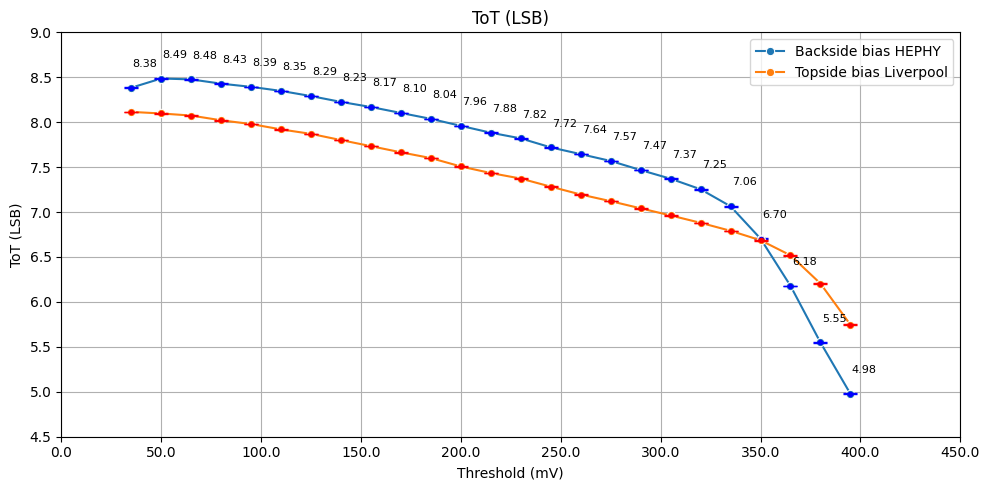

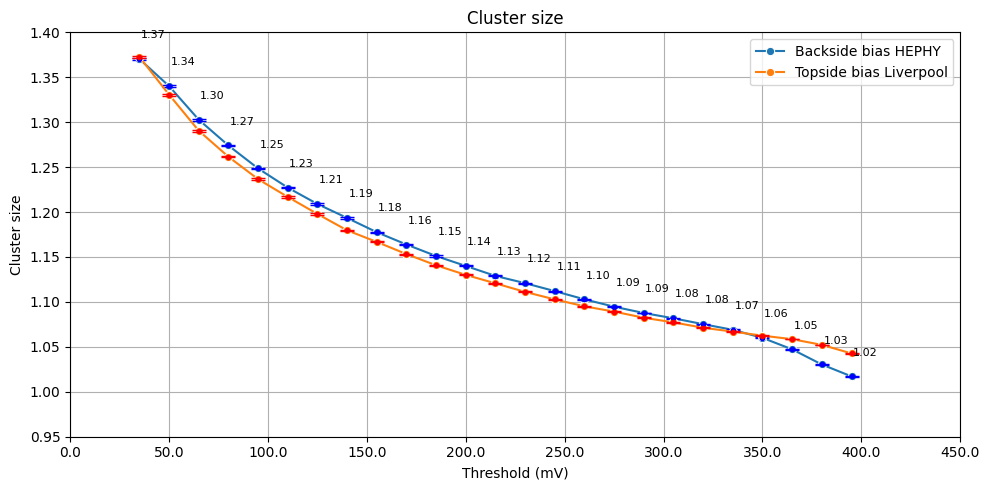

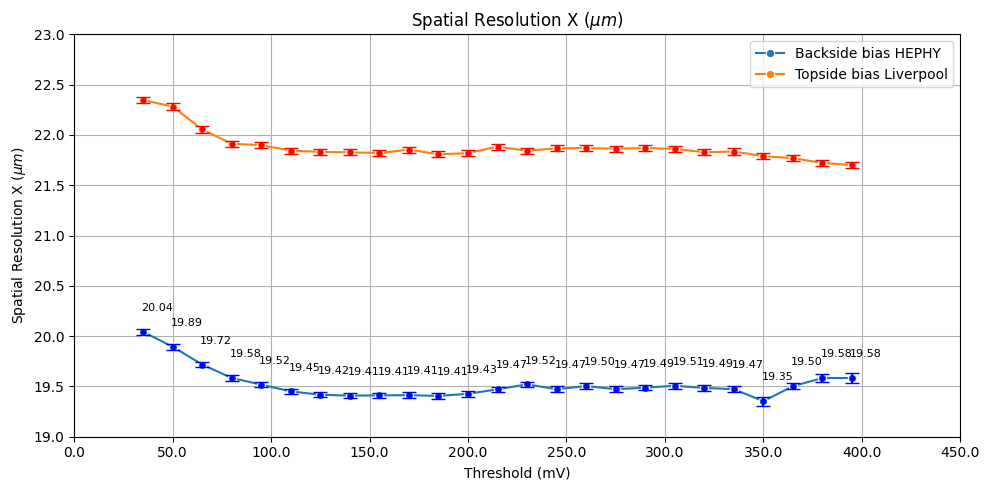

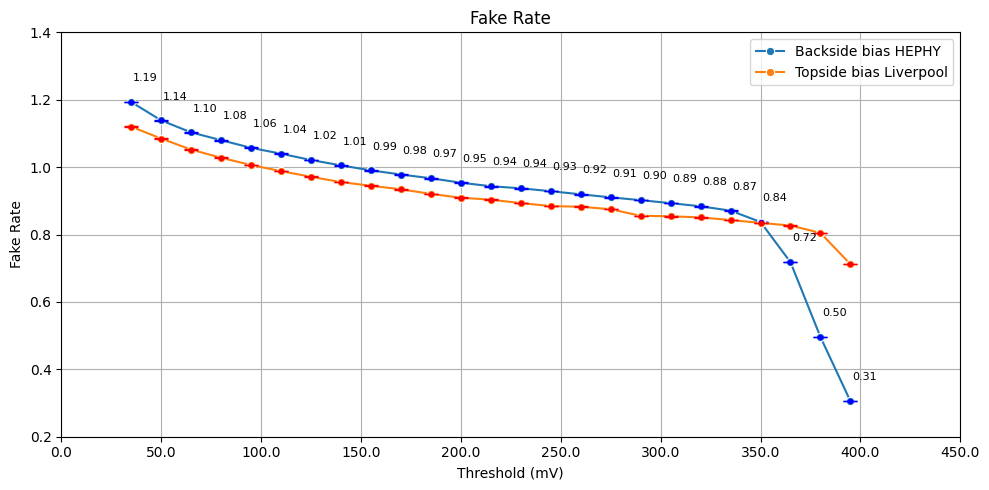

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Your existing code for creating subplots
plt.figure(figsize=(10, 5))

#df1 = df[df["list"]=='Chip1']
#df2 = df[df["list"]=='Chip1']

#df = df2

for i, key in enumerate(keys_to_extract):

    plt.figure(figsize=(10, 5))
    df = df_test
    df = df[df["list"]== name1]
    df
    
    keyrows = df[df['Key'].str.contains(key[0])]  # Get sub dataframe where all rows containing the current key are in
    #plt.subplot(4, 1, i + 1) 
    
    x = keyrows['xVal']
    y = keyrows['Mean']
    # hacky special treatment
    if 'residuals' in key[0]:
        y = keyrows['StdDev']
    
    yerr = df[df['Key'].str.contains(key[0])]['StdErr'].values
    
    # Plot a line plot with error bars
    sns.lineplot(x=x, y=y, label=name1, marker='o')
    plt.errorbar(x, y, yerr=yerr, fmt='.', color='blue', capsize=5)  # Add error bars
    annotate_points(df, key[0])


    df = df_test
    df = df[df["list"]== name2]
    
    keyrows = df[df['Key'].str.contains(key[0])]  # Get sub dataframe where all rows containing the current key are in
    #plt.subplot(4, 1, i + 1) 
    
    x = keyrows['xVal']
    y = keyrows['Mean']
    # hacky special treatment
    if 'residuals' in key[0]:
        y = keyrows['StdDev']
    
    yerr = df[df['Key'].str.contains(key[0])]['StdErr'].values
    
    # Plot a line plot with error bars
    sns.lineplot(x=x, y=y, label=name2, marker='o')
    plt.errorbar(x, y, yerr=yerr, fmt='.', color='red', capsize=5)  # Add error bars
    
    plt.xlabel('')
    plt.ylabel(key[1])
    plt.title(key[1])
    #annotate_points(df, key[0])

    # Add grid lines for both x-axis and y-axis in all subplots
    plt.grid(True, which='both')

    # Set y-ticks for all subplots

    #Create second x-axis
    # ax3 = plt.secondary_xaxis("top")
    # ax3.set_xticks(ax1.get_xticks())
    # ax3.set_xbound(ax1.get_xbound())
    # ax3.set_xticklabels([round((6.61133080e-06*np.power(x,3)-4.41590811e-03*np.power(x,2)+1.64285116e+00*x+8.25602665e+01)*2.8*6.242) for x in ax1.get_xticks()])
    # #ax3.set_xticklabels([round((x * 0.809 + 120.71)*2.8*6.242) for x in ax1.get_xticks()]) #linear fit
    # ax3.set_xlabel("Q (e)")

    
    plt.gca().set_yticks(plt.gca().get_yticks())

    ax = plt.gca()  # Get the current axis (last subplot)
    ax.set_xticks(ax.get_xticks())  # This line refreshes the tick locations
    ax.set_xticklabels(ax.get_xticks())  # Set tick labels to be the same as tick locations
    plt.xlabel(x_name)
    plt.tight_layout()
    plt.savefig(output_file+key[1]+'.svg')
    #plt.show()


# Adjust layout
plt.tight_layout()


plt.show()
